- connecting to colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Faculdade/NLP/final-project/

/content/drive/MyDrive/Faculdade/NLP/final-project


# NLP Final Project

In [19]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Bidirectional, GRU, LSTM, Embedding, Conv1D, GlobalAveragePooling1D, Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import spacy

In [4]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

## Data Preprocessing

In [104]:
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
from tqdm import tqdm


def load_txt_file(path):
    train_df = pd.read_csv(f"{path}/train.txt", sep=';', header=None, names=['Text', 'Label'])
    test_df = pd.read_csv(f"{path}/test.txt", sep=';', header=None, names=['Text', 'Label'])


    train_texts = train_df['Text'].tolist()
    train_labels = train_df['Label'].tolist()

    test_texts = test_df['Text'].tolist()
    test_labels = test_df['Label'].tolist()


    return train_texts, train_labels, test_texts, test_labels

train_texts, train_labels, test_texts, test_labels = load_txt_file('NLP_exam_emotions_dataset')

train_texts= np.asarray(train_texts)
train_labels= np.asarray(train_labels)
test_texts= np.asarray(test_texts)
test_labels= np.asarray(test_labels)

In [7]:
set(train_labels)

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [48]:
def preprocess_labels(train_labels, test_labels):
    labels_map = {
        'anger': 0.0,
        'fear': 1.0,
        'joy': 2.0,
        'love': 3.0,
        'sadness': 4.0,
        'surprise': 5.0,
    }

    test_labels_int = [labels_map[x] for x in test_labels]
    train_labels_int = [labels_map[x] for x in train_labels]

    ohe_train_labels = to_categorical(train_labels_int, num_classes=6)
    ohe_test_labels = to_categorical(test_labels_int, num_classes=6)

    return ohe_train_labels, ohe_test_labels

def tokenize_and_pad_sequences(train_texts, test_texts):
    oov_tok = "<OOV>"

    tokenizer = Tokenizer(num_words = 5000, oov_token = oov_tok )
    tokenizer.fit_on_texts(train_texts)

    vocab_size = len(tokenizer.word_index)+1

    train_sequences = tokenizer.texts_to_sequences(train_texts)
    test_sequences = tokenizer.texts_to_sequences(test_texts)

    train_padded = pad_sequences(train_sequences, truncating='post', maxlen=120)
    test_padded = pad_sequences(test_sequences, maxlen=120)

    return train_padded, test_padded, vocab_size


ohe_train_labels, ohe_test_labels = preprocess_labels(train_labels,test_labels)
train_texts_pad, test_texts_pad, vocab_size= tokenize_and_pad_sequences(train_texts, test_texts)

## Fully Connected Neural Network

In [52]:
model = tf.keras.models.Sequential([
    Embedding(vocab_size, 64, input_length=120),
    Flatten(),
    Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 120, 64)           973696    
                                                                 
 flatten_14 (Flatten)        (None, 7680)              0         
                                                                 
 dense_43 (Dense)            (None, 64)                491584    
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 16)                1040      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_45 (Dense)            (None, 6)               

In [53]:

history = model.fit(train_texts_pad, ohe_train_labels, epochs = 50, batch_size= 100, validation_data=(test_texts_pad, ohe_test_labels))


Epoch 1/50
160/160 [==============================] - 5s 24ms/step - loss: 1.8582 - accuracy: 0.3186 - val_loss: 1.6472 - val_accuracy: 0.3475
Epoch 2/50
160/160 [==============================] - 4s 22ms/step - loss: 1.6148 - accuracy: 0.3349 - val_loss: 1.5023 - val_accuracy: 0.4610
Epoch 3/50
160/160 [==============================] - 5s 30ms/step - loss: 1.3756 - accuracy: 0.4668 - val_loss: 1.1911 - val_accuracy: 0.5930
Epoch 4/50
160/160 [==============================] - 4s 22ms/step - loss: 1.1247 - accuracy: 0.6399 - val_loss: 1.0564 - val_accuracy: 0.6970
Epoch 5/50
160/160 [==============================] - 4s 22ms/step - loss: 1.0119 - accuracy: 0.7072 - val_loss: 1.0001 - val_accuracy: 0.7180
Epoch 6/50
160/160 [==============================] - 4s 23ms/step - loss: 0.9390 - accuracy: 0.7237 - val_loss: 0.9662 - val_accuracy: 0.7230
Epoch 7/50
160/160 [==============================] - 5s 29ms/step - loss: 0.8933 - accuracy: 0.7366 - val_loss: 0.9564 - val_accuracy: 0.7150

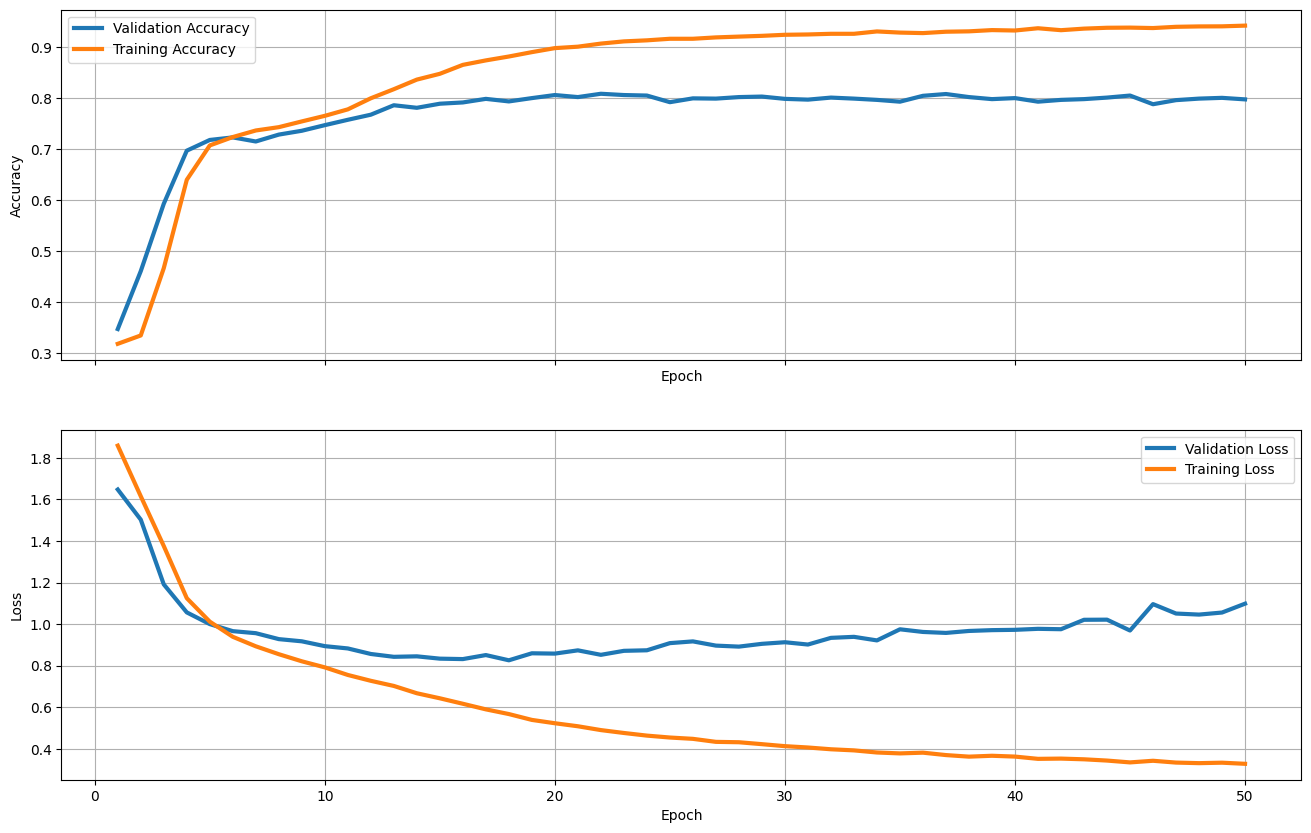

In [54]:
plot_results(history)

## Recurrent Neural Network

In [55]:
model = tf.keras.models.Sequential([
    Embedding(vocab_size, 64, input_length=120),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu'),
    Dense(6, activation='sigmoid')
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 120, 64)           973696    
                                                                 
 bidirectional (Bidirection  (None, 64)                18816     
 al)                                                             
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 6)                 198       
                                                                 
Total params: 994790 (3.79 MB)
Trainable params: 994790 (3.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:

history = model.fit(train_texts_pad, ohe_train_labels, epochs = 50, batch_size= 100, validation_data=(test_texts_pad, ohe_test_labels))

Epoch 1/50
160/160 [==============================] - 24s 127ms/step - loss: 1.5327 - accuracy: 0.3816 - val_loss: 1.2966 - val_accuracy: 0.5100
Epoch 2/50
160/160 [==============================] - 19s 117ms/step - loss: 0.9258 - accuracy: 0.6744 - val_loss: 0.6178 - val_accuracy: 0.8175
Epoch 3/50
160/160 [==============================] - 18s 115ms/step - loss: 0.4429 - accuracy: 0.8728 - val_loss: 0.4485 - val_accuracy: 0.8635
Epoch 4/50
160/160 [==============================] - 21s 133ms/step - loss: 0.3018 - accuracy: 0.9116 - val_loss: 0.4013 - val_accuracy: 0.8705
Epoch 5/50
160/160 [==============================] - 19s 122ms/step - loss: 0.2337 - accuracy: 0.9271 - val_loss: 0.3576 - val_accuracy: 0.8835
Epoch 6/50
160/160 [==============================] - 20s 126ms/step - loss: 0.1975 - accuracy: 0.9352 - val_loss: 0.3380 - val_accuracy: 0.8855
Epoch 7/50
160/160 [==============================] - 18s 116ms/step - loss: 0.1669 - accuracy: 0.9405 - val_loss: 0.3057 - val_ac

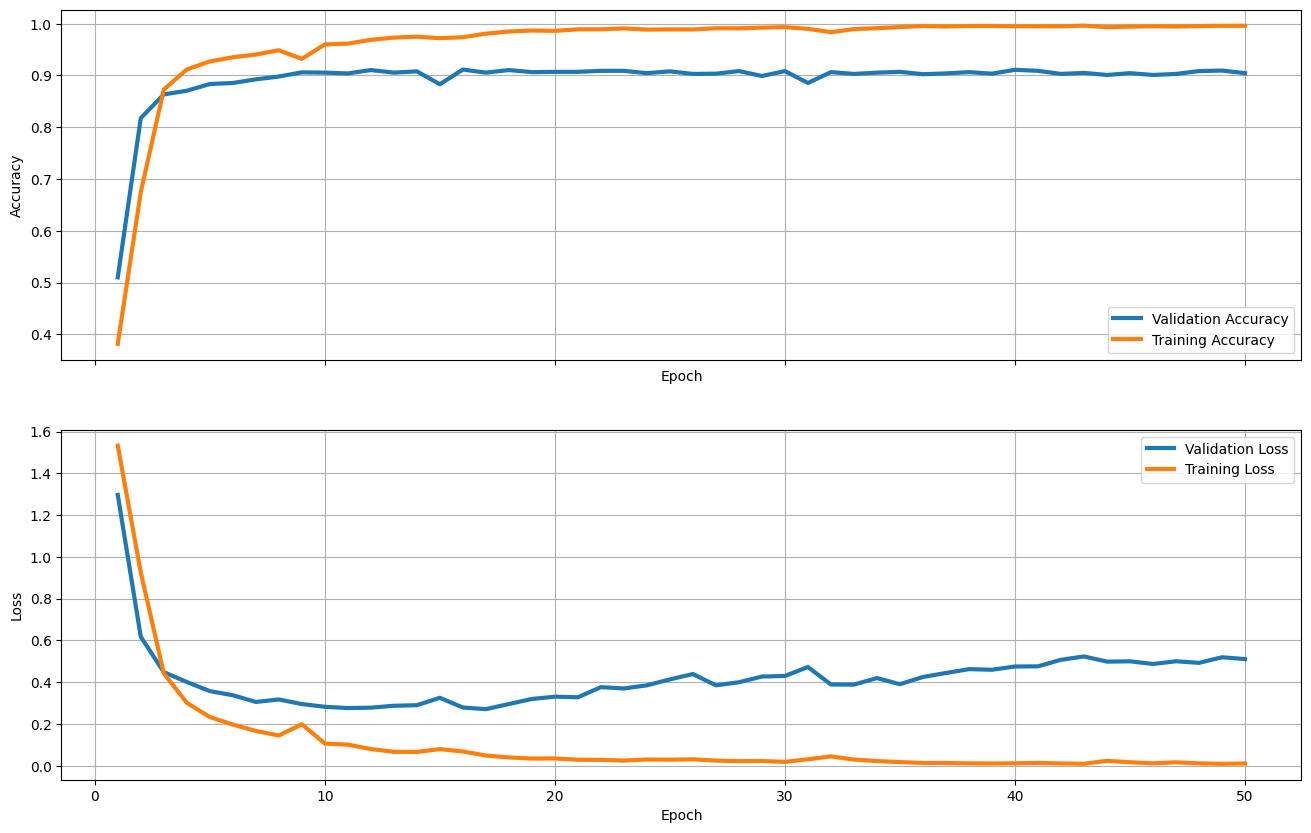

In [57]:
plot_results(history)